In [39]:
leader_id = "leader_qqq"
follower_id = "follower_qqq"

leader_port  = "COM4"
follower_port = "COM3"

In [1]:
from lerobot import find_port
find_port.find_port() 

ImportError: cannot import name 'find_port' from 'lerobot' (c:\Users\jiang\anaconda3\envs\lerobot\lib\site-packages\lerobot\__init__.py)

In [40]:
# Calibration follower
# RUN CALIBRATION IN TERMINAL FOR KEYBOARD INPUT
# First you need to move the robot to the position where all joints are in the middle of their ranges. 
# Then after pressing enter you have to move each joint through its full range of motion.


#Calibration saved to C:\Users\jiang\.cache\huggingface\lerobot\calibration\\robots\so101_follower\\follower_qqq.json


from lerobot.robots.so101_follower import SO101FollowerConfig, SO101Follower

config = SO101FollowerConfig(
    port=follower_port,
    id=follower_id,
)

follower = SO101Follower(config)
# follower.connect(calibrate=False)
# follower.calibrate()
# follower.disconnect()

In [1]:
# check if cuda is available
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: False


## Teleoperate

In [24]:
from lerobot.teleoperators.so101_leader import SO101LeaderConfig, SO101Leader
from lerobot.robots.so101_follower import SO101FollowerConfig, SO101Follower

robot_config = SO101FollowerConfig(
    port=follower_port,
    id=follower_id,
)

teleop_config = SO101LeaderConfig(
    port=leader_port,
    id=leader_id,
)

robot = SO101Follower(robot_config)
teleop_device = SO101Leader(teleop_config)
robot.connect()
teleop_device.connect()

while True:
    action = teleop_device.get_action()
    robot.send_action(action)

KeyboardInterrupt: 

In [27]:
robot.disconnect()
teleop_device.disconnect()

DeviceNotConnectedError: follower_qqq SO101Follower is not connected.

In [6]:
import cv2
from IPython.display import display, Image,clear_output
from PIL import Image as PILImage
import io

def display_webcam_feed(camera_index=0):
    """
    Opens a webcam feed and displays it in a Jupyter Notebook cell.
    Press 'q' in the cell to stop the feed.
    """
    cap = cv2.VideoCapture(camera_index, cv2.CAP_DSHOW)

    if not cap.isOpened():
        print(f"Error: Could not open webcam with index {camera_index}.")
        return

    try:
        while True:
            ret, frame = cap.read()

            if not ret:
                print("Error: Failed to capture frame.")
                break

            # Convert the OpenCV BGR image to RGB for PIL
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = PILImage.fromarray(rgb_frame)

            # Save the PIL image to a byte array and display it
            with io.BytesIO() as output_buffer:
                pil_image.save(output_buffer, format="JPEG")
                display(Image(data=output_buffer.getvalue()))

            # Clear the previous output to simulate a live feed
            clear_output(wait=True)

            # You can add a condition to break the loop, e.g., after a certain time
            # or based on user input if you can capture it within the notebook
            # For simplicity, this example runs indefinitely until interrupted or 'q' is pressed
            # Note: Capturing keyboard input in a live Jupyter output is complex.
            # You might need to manually interrupt the cell execution.

    except KeyboardInterrupt:
        print("Webcam feed stopped by user.")
    finally:
        cap.release()
        print("Webcam released.")

# Call the function to start the webcam feed
display_webcam_feed(camera_index=0) 

Webcam feed stopped by user.
Webcam released.


## Dataset

In [1]:
from lerobot.datasets.lerobot_dataset import LeRobotDataset
from lerobot.datasets.utils import hw_to_dataset_features

c:\Users\jiang\anaconda3\envs\lerobot\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
repo_id = "jqhisme/lerobot-lecamera-dataset-filtered"
dataset = LeRobotDataset(repo_id)

In [46]:
dataset[0]['observation.images.front'].shape

c:\Users\jiang\anaconda3\envs\lerobot\lib\site-packages\torchvision\io\_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


torch.Size([3, 480, 640])

In [47]:
dataset.add_frame

<bound method LeRobotDataset.add_frame of LeRobotDataset({
    Repository ID: 'jqhisme/lerobot-lecamera-dataset-filtered',
    Number of selected episodes: '19',
    Number of selected samples: '29274',
    Features: '['action', 'observation.state', 'observation.images.front', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index']',
})',
>

In [48]:
new_features = dataset.features.copy()
new_features["segmented_mask"] = {'dtype': 'video',
 'shape': (480, 640, 1),
 'names': ['height', 'width', 'channels'],
 'info': {'video.height': 480,
  'video.width': 640,
  'video.codec': 'av1',
  'video.pix_fmt': 'yuv420p',
  'video.is_depth_map': False,
  'video.fps': 30,
  'video.channels': 1,
  'has_audio': False}}

In [49]:
new_features.keys()

dict_keys(['action', 'observation.state', 'observation.images.front', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index', 'segmented_mask'])

In [65]:
from ultralytics import YOLO
import torch

model = YOLO("yolo11n-seg.pt")
model.to(torch.device("cuda"))

for i in range(len(dataset)):
    data = dataset[i].copy()
    image = data['observation.images.front']
    # image range from 0 to 1, type torch.tensor
    r = model(image.unsqueeze(0), verbose=False)[0]

    # create binary mask for person class (class 0)
    if r.masks is None:
        binary_mask = torch.zeros((1, 480, 640), device=image.device)
    else:
        person_idxs = (r.boxes.cls == 0)
        if person_idxs.sum() == 0:
            binary_mask = torch.zeros((1, 480, 640), device=image.device)
        else:
            binary_mask = r.masks.data[person_idxs].any(dim=0).float().unsqueeze(0)
    
    data['segmented_mask'] = binary_mask.permute(1, 2, 0)
    data['observation.images.front'] = image.permute(1, 2, 0)
    print(data.keys())
    break

dict_keys(['observation.images.front', 'action', 'observation.state', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index', 'task', 'segmented_mask'])


c:\Users\jiang\anaconda3\envs\lerobot\lib\site-packages\torchvision\io\_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


In [59]:
data.keys()

dict_keys(['observation.images.front', 'action', 'observation.state', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index', 'task', 'segmented_mask'])

In [66]:
dataset[0]

{'observation.images.front': tensor([[[0.4824, 0.4784, 0.4784,  ..., 0.5020, 0.4980, 0.4980],
          [0.4784, 0.4784, 0.4784,  ..., 0.5137, 0.5176, 0.5255],
          [0.4745, 0.4745, 0.4745,  ..., 0.4745, 0.4745, 0.4784],
          ...,
          [0.4275, 0.4510, 0.4863,  ..., 0.3529, 0.3725, 0.4078],
          [0.4275, 0.4510, 0.4863,  ..., 0.3529, 0.3765, 0.4118],
          [0.4275, 0.4510, 0.4863,  ..., 0.3529, 0.3804, 0.4157]],
 
         [[0.5412, 0.5373, 0.5373,  ..., 0.5529, 0.5490, 0.5490],
          [0.5373, 0.5373, 0.5373,  ..., 0.5647, 0.5686, 0.5765],
          [0.5333, 0.5333, 0.5333,  ..., 0.5373, 0.5373, 0.5412],
          ...,
          [0.4745, 0.4980, 0.5098,  ..., 0.4000, 0.4157, 0.4510],
          [0.4745, 0.4980, 0.5098,  ..., 0.4000, 0.4196, 0.4549],
          [0.4745, 0.4980, 0.5098,  ..., 0.4000, 0.4235, 0.4588]],
 
         [[0.4314, 0.4275, 0.4275,  ..., 0.4980, 0.4941, 0.4941],
          [0.4275, 0.4275, 0.4275,  ..., 0.5098, 0.5137, 0.5216],
          [0

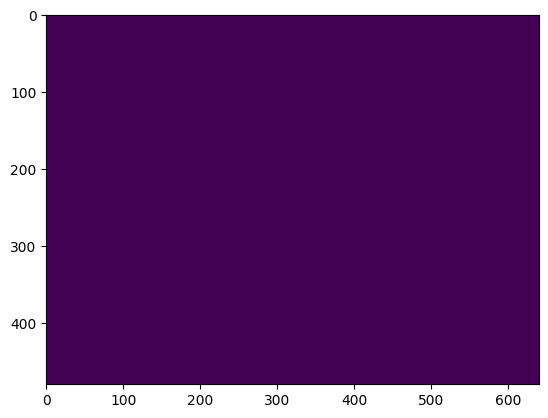

In [73]:
import matplotlib.pyplot as plt

plt.imshow(data['segmented_mask'].cpu().numpy())

In [68]:
dataset[0]

{'observation.images.front': tensor([[[0.4824, 0.4784, 0.4784,  ..., 0.5020, 0.4980, 0.4980],
          [0.4784, 0.4784, 0.4784,  ..., 0.5137, 0.5176, 0.5255],
          [0.4745, 0.4745, 0.4745,  ..., 0.4745, 0.4745, 0.4784],
          ...,
          [0.4275, 0.4510, 0.4863,  ..., 0.3529, 0.3725, 0.4078],
          [0.4275, 0.4510, 0.4863,  ..., 0.3529, 0.3765, 0.4118],
          [0.4275, 0.4510, 0.4863,  ..., 0.3529, 0.3804, 0.4157]],
 
         [[0.5412, 0.5373, 0.5373,  ..., 0.5529, 0.5490, 0.5490],
          [0.5373, 0.5373, 0.5373,  ..., 0.5647, 0.5686, 0.5765],
          [0.5333, 0.5333, 0.5333,  ..., 0.5373, 0.5373, 0.5412],
          ...,
          [0.4745, 0.4980, 0.5098,  ..., 0.4000, 0.4157, 0.4510],
          [0.4745, 0.4980, 0.5098,  ..., 0.4000, 0.4196, 0.4549],
          [0.4745, 0.4980, 0.5098,  ..., 0.4000, 0.4235, 0.4588]],
 
         [[0.4314, 0.4275, 0.4275,  ..., 0.4980, 0.4941, 0.4941],
          [0.4275, 0.4275, 0.4275,  ..., 0.5098, 0.5137, 0.5216],
          [0

## Yolo Feature Map

In [77]:
model = YOLO("yolo11n-seg.pt")

Conv(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)

In [ ]:
import torch

# Dictionary to store captured feature maps
captured_features = {}

def hook_fn(name):
    def hook(module, input, output):
        captured_features[name] = output
    return hook

# Register hooks
# Hook 1: End of encoder/backbone - hook at C2PSA layer (index 10)
encoder_hook = model.model.model[10].register_forward_hook(hook_fn("encoder_output"))

# Hook 2: Right before Segment layer - hook at the last C3k2 layer before Segment (index 24)
pre_segment_hook = model.model.model[24].register_forward_hook(hook_fn("pre_segment_output"))

# Create a noise image: (1, 3, 480, 640) for batch processing
noise_image = torch.randn(1, 3, 480, 640, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Forward pass
with torch.no_grad():
    _ = model(noise_image, verbose=False)

# Print feature map sizes
print("Feature map sizes:")
print(f"  Encoder output shape: {captured_features['encoder_output'].shape}")
print(f"  Pre-segment output shape: {captured_features['pre_segment_output'].shape}")

# Remove hooks
encoder_hook.remove()
pre_segment_hook.remove()

Conv(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)
Conv(
  (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)
C3k2(
  (cv1): Conv(
    (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (m): ModuleList(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

In [97]:
model.model.model[-2]

C3k2(
  (cv1): Conv(
    (conv): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (m): ModuleList(
    (0): C3k(
      (cv1): Conv(
        (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv3): Conv(
        (conv): Conv2d(128, 128, kerne

# Viz

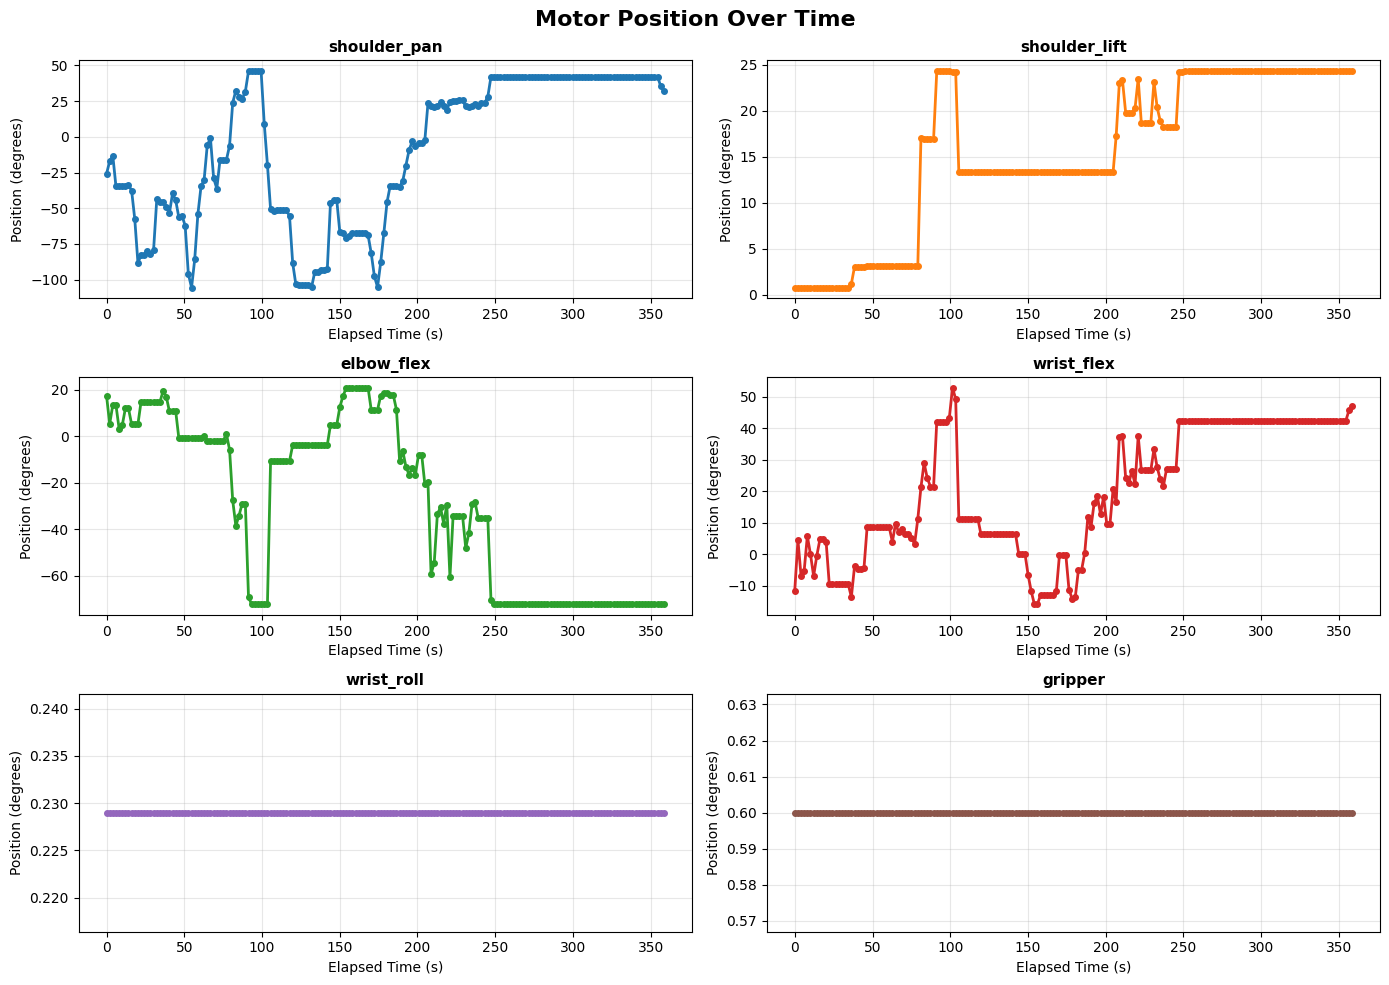


=== Motor Position Statistics ===
Total duration: 358.46 seconds
Number of samples: 178

Position ranges (min, max, mean):
  shoulder_pan   : min=-105.516°, max=  46.039°, mean=  -9.760°
  shoulder_lift  : min=   0.769°, max=  24.280°, mean=  15.462°
  elbow_flex     : min= -72.190°, max=  20.849°, mean= -28.503°
  wrist_flex     : min= -15.820°, max=  52.885°, mean=  19.672°
  wrist_roll     : min=   0.229°, max=   0.229°, mean=   0.229°
  gripper        : min=   0.600°, max=   0.600°, mean=   0.600°


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
csv_path = r"C:\Users\jiang\Desktop\NYU ITP\Computer Vision\Armie\motor_log_20251219_172801.csv"
df = pd.read_csv(csv_path)

# Convert timestamp to datetime for better x-axis
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate elapsed time in seconds
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds()

# Create figure with subplots (6 joints)
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Motor Position Over Time', fontsize=16, fontweight='bold')

joint_names = ['shoulder_pan', 'shoulder_lift', 'elbow_flex', 'wrist_flex', 'wrist_roll', 'gripper']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

for idx, (joint_name, color) in enumerate(zip(joint_names, colors)):
    ax = axes_flat[idx]
    ax.plot(df['elapsed_time'], df[joint_name], marker='o', linestyle='-', color=color, linewidth=2, markersize=4)
    ax.set_xlabel('Elapsed Time (s)', fontsize=10)
    ax.set_ylabel('Position (degrees)', fontsize=10)
    ax.set_title(joint_name, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== Motor Position Statistics ===")
print(f"Total duration: {df['elapsed_time'].max():.2f} seconds")
print(f"Number of samples: {len(df)}")
print("\nPosition ranges (min, max, mean):")
for joint_name in joint_names:
    min_val = df[joint_name].min()
    max_val = df[joint_name].max()
    mean_val = df[joint_name].mean()
    print(f"  {joint_name:15s}: min={min_val:8.3f}°, max={max_val:8.3f}°, mean={mean_val:8.3f}°")

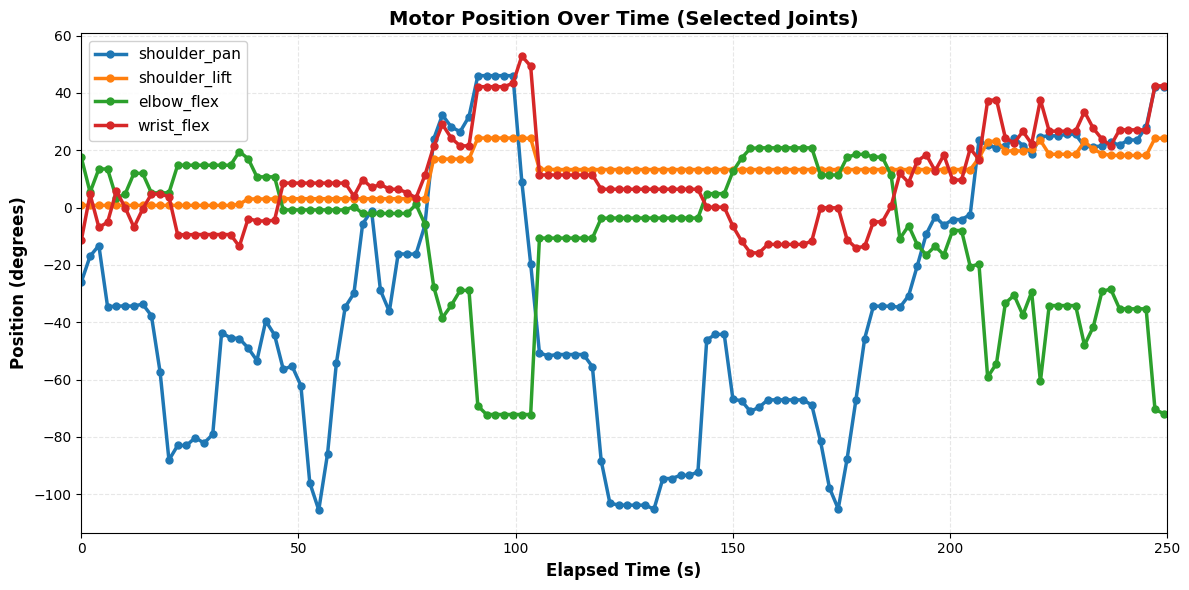

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
csv_path = r"C:\Users\jiang\Desktop\NYU ITP\Computer Vision\Armie\motor_log_20251219_172801.csv"
df = pd.read_csv(csv_path)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate elapsed time in seconds
df['elapsed_time'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds()

# Create a single plot with selected joints
fig, ax = plt.subplots(figsize=(12, 6))

selected_joints = ['shoulder_pan', 'shoulder_lift', 'elbow_flex', 'wrist_flex']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for joint_name, color in zip(selected_joints, colors):
    ax.plot(df['elapsed_time'], df[joint_name], marker='o', linestyle='-', 
            color=color, linewidth=2.5, markersize=5, label=joint_name)

ax.set_xlabel('Elapsed Time (s)', fontsize=12, fontweight='bold')
ax.set_ylabel('Position (degrees)', fontsize=12, fontweight='bold')
ax.set_title('Motor Position Over Time (Selected Joints)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=11, framealpha=0.9)

plt.xlim(0,250)
plt.tight_layout()
plt.show()

Total entries: 30813
State data shape: (5000, 6)
First sample: [  3.2700849 -99.914055   99.18955    67.88618     8.083376   15.189874 ]


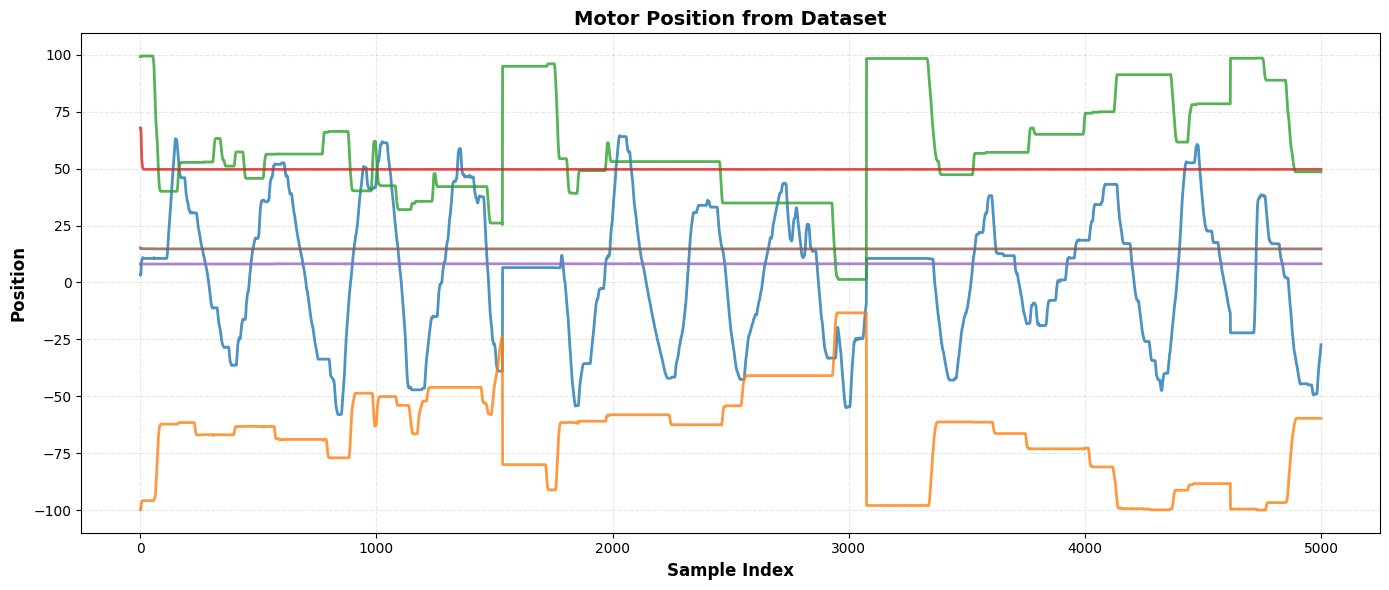

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the parquet file
parquet_path = r"C:\Users\jiang\.cache\huggingface\lerobot\jqhisme\lerobot-lecamera-dataset\data\chunk-000\file-000.parquet"
df = pd.read_parquet(parquet_path)

print(f"Total entries: {len(df)}")

# Take only first 250 entries
df_truncated = df.head(5000).copy()

# Extract observation.state and convert to array
state_data = np.array([np.array(x) for x in df_truncated['observation.state']])

print(f"State data shape: {state_data.shape}")
print(f"First sample: {state_data[0]}")

# Create a single plot with all 6 joints
fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
sample_indices = range(len(state_data))

# Plot each joint (each column in state_data)
for joint_idx in range(state_data.shape[1]):
    ax.plot(sample_indices, state_data[:, joint_idx], linewidth=2, color=colors[joint_idx], alpha=0.8)

ax.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Position', fontsize=12, fontweight='bold')
ax.set_title('Motor Position from Dataset', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [12]:
df['observation.state']

0        [3.2700849, -99.914055, 99.18955, 67.88618, 8....
1        [3.2700849, -99.914055, 99.18955, 67.88618, 8....
2        [3.2700849, -99.8281, 99.18955, 67.72358, 8.08...
3        [4.8041987, -98.45294, 99.18955, 66.01626, 8.0...
4        [7.7916837, -97.335625, 99.18955, 61.788616, 8...
                               ...                        
30808    [16.269682, -33.90632, 26.789734, 62.682926, 8...
30809    [17.96528, -33.90632, 26.789734, 62.682926, 8....
30810    [20.22608, -33.90632, 26.789734, 62.682926, 8....
30811    [21.598707, -33.90632, 26.789734, 62.682926, 8...
30812    [22.80985, -33.90632, 26.789734, 62.682926, 8....
Name: observation.state, Length: 30813, dtype: object

In [ ]:
# C:\Users\jiang\.cache\huggingface\lerobot\jqhisme\lerobot-lecamera-dataset\data\chunk-000\file-000.parquet

## log visualizarion

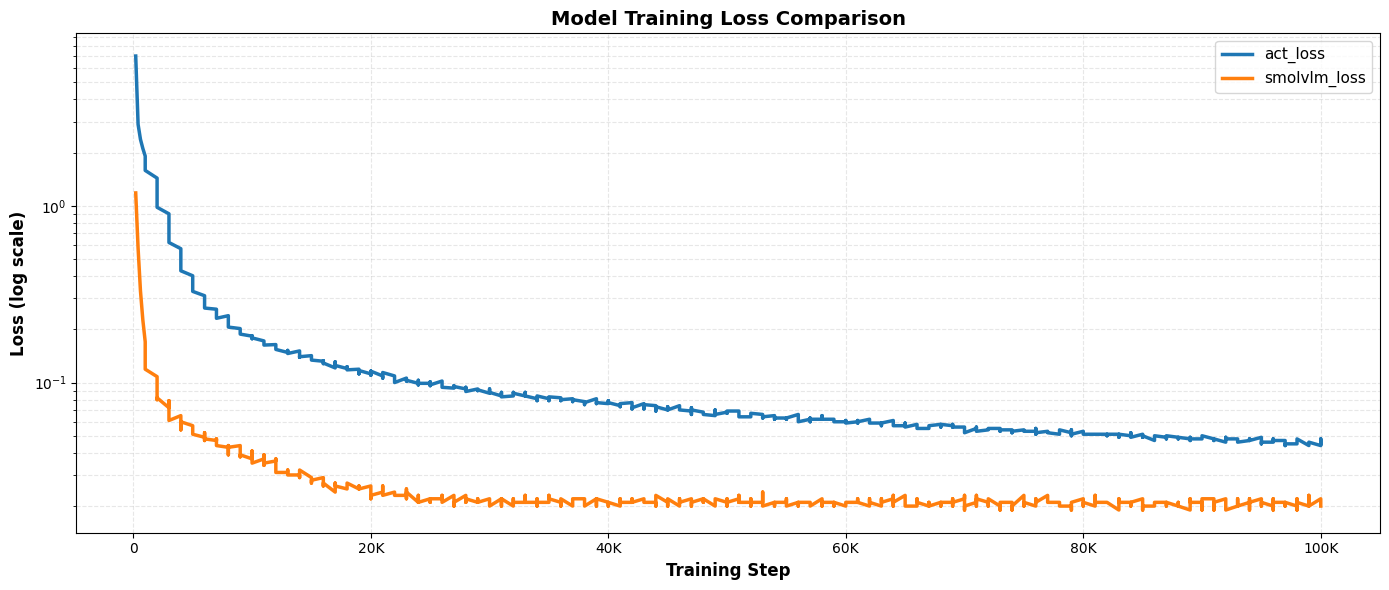


=== ACT Model Training Loss Statistics ===
Total training steps tracked: 500
Initial loss: 7.040
Final loss: 0.045
Loss decrease: 6.995 (99.4%)
Minimum loss: 0.044 at step 97K

=== SmolVLM Model Training Loss Statistics ===
Total training steps tracked: 500
Initial loss: 1.183
Final loss: 0.020
Loss decrease: 1.163 (98.3%)
Minimum loss: 0.019 at step 70K


In [32]:
import re
import matplotlib.pyplot as plt

def extract_loss_from_log(log_path):
    """Extract loss values and steps from a log file"""
    loss_values = []
    steps = []
    
    with open(log_path, 'r') as f:
        lines = f.readlines()
    
    pattern = r"step:(\d+[KMG]?)\s+.*loss:([\d.]+)"
    
    for line in lines:
        # Look for training metric lines (any line from rc/train.py with loss:)
        if "rc/train.py:" in line and "loss:" in line:
            match = re.search(pattern, line)
            if match:
                step_str = match.group(1)
                loss_str = match.group(2)
                
                # Convert step string to number
                if 'K' in step_str:
                    step_num = int(step_str.replace('K', '')) * 1000
                elif 'M' in step_str:
                    step_num = int(step_str.replace('M', '')) * 1000000
                else:
                    step_num = int(step_str)
                
                steps.append(step_num)
                loss_values.append(float(loss_str))
    
    return steps, loss_values

# Read both log files
act_log_path = r"C:\Users\jiang\Desktop\NYU ITP\Computer Vision\Armie\src\logs\act.log"
smolvlm_log_path = r"C:\Users\jiang\Desktop\NYU ITP\Computer Vision\Armie\src\logs\smolvlm.log"

act_steps, act_loss = extract_loss_from_log(act_log_path)

# Try to read smolvlm.log
try:
    smolvlm_steps, smolvlm_loss = extract_loss_from_log(smolvlm_log_path)
    has_smolvlm = len(smolvlm_loss) > 0
except:
    has_smolvlm = False
    print("smolvlm.log not found or is empty")

# Create visualization
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(act_steps, act_loss, linestyle='-', linewidth=2.5, label='act_loss', color='#1f77b4')

if has_smolvlm:
    ax.plot(smolvlm_steps, smolvlm_loss, linestyle='-', linewidth=2.5, label='smolvlm_loss', color='#ff7f0e')

ax.set_xlabel('Training Step', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss (log scale)', fontsize=12, fontweight='bold')
ax.set_title('Model Training Loss Comparison', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, linestyle='--', which='both')
ax.legend(fontsize=11, loc='upper right')

# Format x-axis to show thousands
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x >= 1000 else str(int(x))))

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n=== ACT Model Training Loss Statistics ===")
print(f"Total training steps tracked: {len(act_steps)}")
print(f"Initial loss: {act_loss[0]:.3f}")
print(f"Final loss: {act_loss[-1]:.3f}")
print(f"Loss decrease: {act_loss[0] - act_loss[-1]:.3f} ({((act_loss[0] - act_loss[-1]) / act_loss[0] * 100):.1f}%)")
print(f"Minimum loss: {min(act_loss):.3f} at step {act_steps[act_loss.index(min(act_loss))]/1000:.0f}K")

if has_smolvlm:
    print(f"\n=== SmolVLM Model Training Loss Statistics ===")
    print(f"Total training steps tracked: {len(smolvlm_steps)}")
    print(f"Initial loss: {smolvlm_loss[0]:.3f}")
    print(f"Final loss: {smolvlm_loss[-1]:.3f}")
    print(f"Loss decrease: {smolvlm_loss[0] - smolvlm_loss[-1]:.3f} ({((smolvlm_loss[0] - smolvlm_loss[-1]) / smolvlm_loss[0] * 100):.1f}%)")
    print(f"Minimum loss: {min(smolvlm_loss):.3f} at step {smolvlm_steps[smolvlm_loss.index(min(smolvlm_loss))]/1000:.0f}K")

Action CSV loaded successfully
Action shape: (500, 6)
Action columns: ['shoulder_pan.pos', 'shoulder_lift.pos', 'elbow_flex.pos', 'wrist_flex.pos', 'wrist_roll.pos', 'gripper.pos']


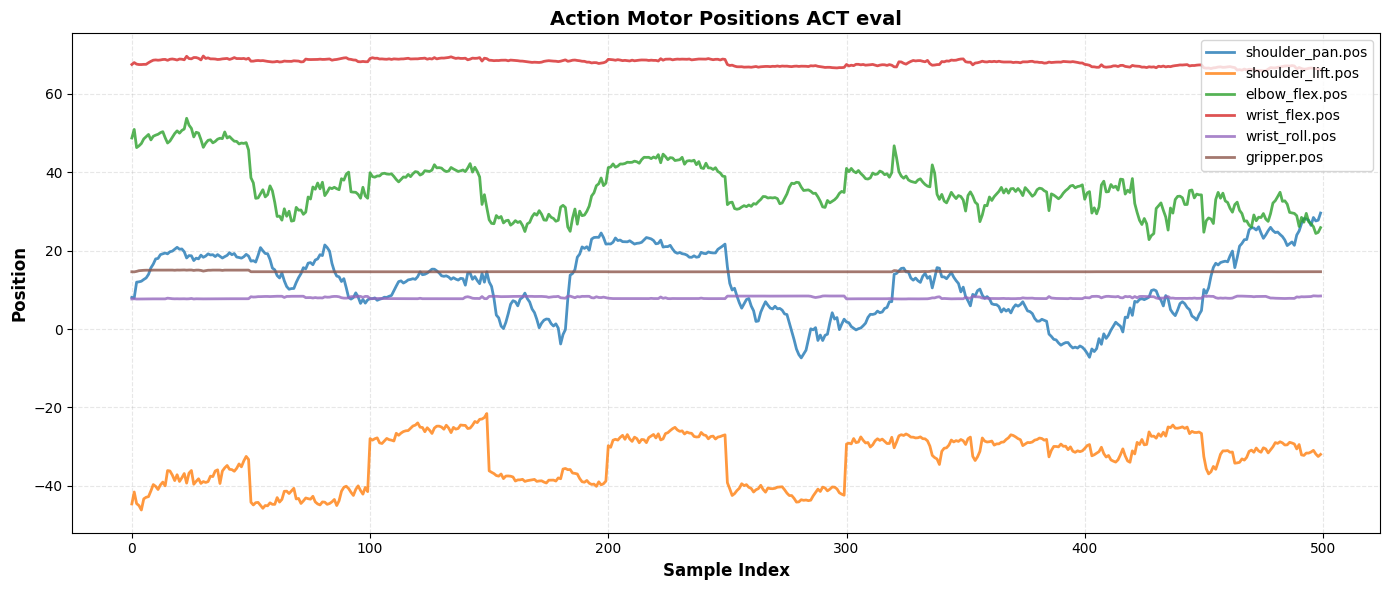

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the action CSV file
action_csv_path = r"C:\Users\jiang\Desktop\NYU ITP\Computer Vision\Armie\src\results\smolvlm\actions.csv"

try:
    action_df = pd.read_csv(action_csv_path)
    print("Action CSV loaded successfully")
    print(f"Action shape: {action_df.shape}")
    print(f"Action columns: {action_df.columns.tolist()}")
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(14, 6))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Get numeric columns (motor names from first row)
    numeric_cols = action_df.select_dtypes(include=[np.number]).columns
    
    for idx, col in enumerate(numeric_cols[:6]):  # Plot first 6 columns
        ax.plot(range(len(action_df)), action_df[col].values, linewidth=2, 
               color=colors[idx % len(colors)], alpha=0.8, label=col)
    
    ax.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
    ax.set_ylabel('Position', fontsize=12, fontweight='bold')
    ax.set_title('Action Motor Positions ACT eval', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=10, loc='best')
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print(f"Action CSV not found at {action_csv_path}")


In [38]:
import os
from PIL import Image
import numpy as np
from pathlib import Path

# Path to the results directory
results_dir = r"C:\Users\jiang\Desktop\NYU ITP\Computer Vision\Armie\src\results\smolvlm"

# Get all PNG files
png_files = sorted([f for f in os.listdir(results_dir) if f.lower().endswith('.png')])
png_files = png_files[:90]  # Take first 90

print(f"Found {len(png_files)} PNG files")

# Image parameters
img_width, img_height = 100, 100  # Resize each image to 100x100
rows, cols = 10, 9  # 10 rows, 9 columns

# Create a large canvas
canvas_width = cols * img_width
canvas_height = rows * img_height
canvas = Image.new('RGB', (canvas_width, canvas_height), color='white')

# Load and place images
for idx, filename in enumerate(png_files):
    if idx >= rows * cols:
        break
    
    img_path = os.path.join(results_dir, filename)
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((img_width, img_height), Image.Resampling.LANCZOS)
        
        # Calculate position
        row = idx // cols
        col = idx % cols
        x = col * img_width
        y = row * img_height
        
        # Paste image onto canvas
        canvas.paste(img, (x, y))
    except Exception as e:
        print(f"Error loading {filename}: {e}")

# Save the result
output_path = os.path.join(results_dir, "aggregated.png")
canvas.save(output_path)
print(f"Grid image saved to: {output_path}")
print(f"Grid size: {canvas_width}x{canvas_height} pixels")


Found 90 PNG files
Grid image saved to: C:\Users\jiang\Desktop\NYU ITP\Computer Vision\Armie\src\results\smolvlm\aggregated.png
Grid size: 900x1000 pixels
